Montaje del google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Carpeta con las imagenes guardadas.

In [2]:
!ls "/content/drive/MyDrive/semantic-segmentation"

dataset


Librerías

In [3]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [4]:
CLASS_COLORS = {
    (237, 34, 236): 1,  # Advertisement
    (201, 158, 74): 2,  # Field
    (96, 32, 192): 3,   # Football
    (89, 134, 179): 4,  # Goal Bar
    (153, 223, 219): 5, # Goalkeeper 1
    (255, 106, 77): 6,  # Goalkeeper 2
    (22, 100, 252): 7,  # Referee
    (143, 182, 45): 8,  # Spectators
    (38, 198, 129): 9,  # Team 1
    (27, 154, 218): 10, # Team 2
    (0, 0, 0): 0        # Background
}

In [5]:
def convert_mask(mask):
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  height, width, _ = mask.shape
  label_mask = np.zeros((height, width), dtype=np.uint8)

  for color, class_idx in CLASS_COLORS.items():
    mask_idx = (mask == color).all(axis=2)
    label_mask[mask_idx] = class_idx

  return label_mask

In [6]:
class SegmentationDataset(Dataset):
  def __init__(self, images_dir, masks_dir, transform=None):
    self.images_dir = images_dir
    self.masks_dir = masks_dir
    self.image_filenames = sorted(os.listdir(images_dir))
    self.mask_filenames = sorted(os.listdir(masks_dir))
    self.transform = transform

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, idx):
    img_path = os.path.join(self.images_dir, self.image_filenames[idx])
    mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = convert_mask(mask)

    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented['image']
      mask = augmented['mask'].long()

    return image, mask

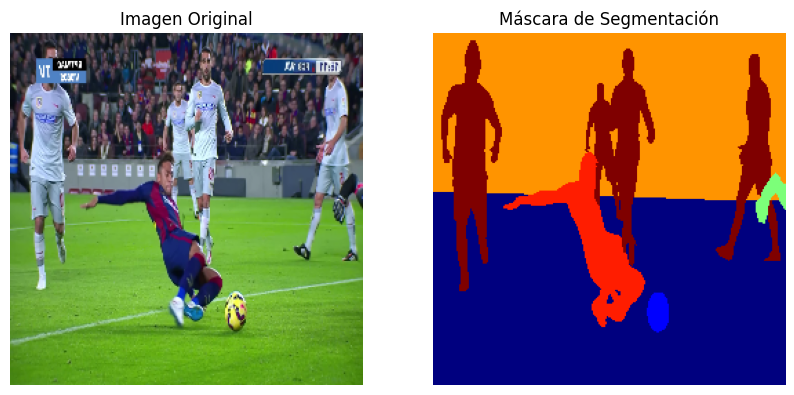

In [7]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

dataset = SegmentationDataset('/content/drive/MyDrive/semantic-segmentation/dataset/images/', '/content/drive/MyDrive/semantic-segmentation/dataset/masks/', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Mean y std usados en Normalize()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Obtener imagen y máscara
img, mask = dataset[0]

# Desnormalizar imagen
img = img.permute(1, 2, 0).numpy()  # Convertir de tensor a numpy (H, W, C)
img = (img * std) + mean  # Revertir Normalize()
img = np.clip(img, 0, 1)  # Asegurar valores en [0,1] para imshow()

# Mostrar imagen y máscara
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)  # Imagen desnormalizada
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(mask.squeeze(), cmap='jet')  # Máscara con colores
ax[1].set_title("Máscara de Segmentación")
ax[1].axis("off")

plt.show()

In [8]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):  # 11 clases (0-10)
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder = nn.ModuleList([
            conv_block(in_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
        ])

        self.bottleneck = conv_block(512, 1024)

        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ])

        self.decoder = nn.ModuleList([
            conv_block(1024, 512),
            conv_block(512, 256),
            conv_block(256, 128),
            conv_block(128, 64),
        ])

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc_features = []

        # Codificador
        for layer in self.encoder:
            x = layer(x)
            enc_features.append(x)
            x = self.pool(x)

        # Botella
        x = self.bottleneck(x)

        # Decodificador
        for i in range(len(self.decoder)):
            x = self.upconvs[i](x)  # Upsampling
            enc_feature = enc_features[-(i+1)]  # Características del encoder correspondientes

            # 🔹 Verifica que los tamaños sean iguales antes de concatenar
            if x.shape != enc_feature.shape:
                diffY = enc_feature.size()[2] - x.size()[2]
                diffX = enc_feature.size()[3] - x.size()[3]
                x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                          diffY // 2, diffY - diffY // 2])

            x = torch.cat([x, enc_feature], dim=1)  # Concatenación correcta
            x = self.decoder[i](x)

        return self.final_conv(x)  # Sin activación, usamos Softmax en la pérdida

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [10]:
# Verifica que tiene parámetros entrenables
print("Número de parámetros entrenables:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Número de parámetros entrenables: 31032395


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
  model.train()

  for epoch in range(epochs):
    epoch_loss = 0

    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}')

train_model(model, dataloader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 6.204944806098938
Epoch 2/10, Loss: 1.4745746016502381
Epoch 3/10, Loss: 0.7551829946041108
Epoch 4/10, Loss: 0.6627230048179626
Epoch 5/10, Loss: 0.6382478451728821
Epoch 6/10, Loss: 0.6208980417251587
Epoch 7/10, Loss: 0.5954644846916198


In [ ]:
def predict_image(model, image_path):
    model.eval()  # Ponemos el modelo en modo evaluación

    # Cargar la imagen
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transformar la imagen como en el entrenamiento
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    image = transform(image=image)['image'].unsqueeze(0).to(device)  # Agregar batch dimension

    # Obtener la predicción
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy().squeeze()

    # Mostrar la imagen original y la máscara predicha
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1])
    ax[0].set_title("Imagen Original")
    ax[0].axis("off")

    ax[1].imshow(predicted_mask, cmap="jet")
    ax[1].set_title("Segmentación Predicha")
    ax[1].axis("off")

    plt.show()

In [ ]:
# Prueba con una imagen nueva
predict_image(model, "/content/drive/MyDrive/semantic-segmentation/images/foto.jpg")